## (dev notebook)

In [1]:
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns



2025-05-29 10:53:24.157619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748541204.257239 2046173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748541204.282668 2046173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 10:53:24.520715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc

from results.run_benchmarks import run_benchmarks
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
)
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import sampler_evaluation
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
# from sampler_comparison.samplers.hamiltonianmontecarlo.unadjusted.underdamped_langevin import unadjusted_lmc
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc
from functools import partial
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc, adjusted_hmc_no_tuning
from sampler_comparison.samplers.grid_search.grid_search import grid_search_adjusted_mclmc
from sampler_comparison.samplers.grid_search.grid_search import grid_search_unadjusted_mclmc, grid_search_hmc
from sampler_comparison.samplers import samplers
from sampler_comparison.samplers.hamiltonianmontecarlo.unadjusted.underdamped_langevin import unadjusted_lmc
import jax.numpy as jnp
import blackjax
from sampler_comparison.samplers.general import (
    with_only_statistics,
    make_log_density_fn,
)
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc_no_tuning

from sampler_evaluation.models.neals_funnel_mams_paper import neals_funnel_mams_paper
from sampler_comparison.util import (
    calls_per_integrator_step,
    map_integrator_type_to_integrator,
)
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import adjusted_mclmc_tuning
from sampler_comparison.samplers.microcanonicalmontecarlo.mchmc import (unadjusted_mchmc_no_tuning, unadjusted_mchmc)

# model=banana()
model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# model = neals_funnel_mams_paper


initial_position = jax.random.normal(jax.random.PRNGKey(0), (model.ndims,))

logdensity_fn = make_log_density_fn(model)

# (
#             blackjax_state_after_tuning,
#             blackjax_mclmc_sampler_params,
#             num_tuning_integrator_steps,
# ) = adjusted_mclmc_tuning(initial_position, num_steps=10000, rng_key=jax.random.key(0), logdensity_fn=logdensity_fn, diagonal_preconditioning=True, target_acc_rate=0.99, random_trajectory_length=True, integrator=map_integrator_type_to_integrator["mclmc"]['velocity_verlet'], L_proposal_factor=jnp.inf, params=None, max="avg", num_windows=1, tuning_factor=1.0, num_tuning_steps=500, L_factor_stage_3=0.3, warmup='nuts')


# sampler = partial(adjusted_mclmc,num_tuning_steps=5000, target_acc_rate=0.99, diagonal_preconditioning=False,)
# samples, metadata = sampler(return_samples=True)(
#         model=model, 
#         num_steps=1000,
#         initial_position=initial_position, 
#         key=jax.random.key(0),
        
#         )

# plt.scatter(samples[:,0], samples[:,-1], alpha=0.5, s=0.3)

L = 5.0
step_size = 0.5
# L = blackjax_mclmc_sampler_params.L
# step_size = blackjax_mclmc_sampler_params.step_size
# L = metadata['L']
# step_size = metadata['step_size']
print("L", L)
print("step_size", step_size)


inverse_mass_matrix = jnp.ones(model.ndims) # jnp.eye(model.ndims)
# inverse_mass_matrix = blackjax_mclmc_sampler_params.inverse_mass_matrix

# initial_state = blackjax.dynamic_hmc.init(
#         position=initial_position,
#         logdensity_fn=logdensity_fn,
#         random_generator_arg=jax.random.key(0),
#         # metric=metrics.default_metric(inverse_mass_matrix)
#     )

initial_state = blackjax.mchmc.init(
        position=initial_position,
        logdensity_fn=logdensity_fn,
        rng_key=jax.random.key(0),
        # metric=metrics.default_metric(inverse_mass_matrix)
    )

# sampler = partial(adjusted_hmc,num_tuning_steps=5000, integrator_type="velocity_verlet", L_proposal_factor=1.25)

sampler = partial(unadjusted_mchmc_no_tuning,integrator_type="velocity_verlet", L=L, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, initial_state=initial_state)
# sampler = partial(unadjusted_mchmc,num_tuning_steps=1000)

samples, metadata = sampler(return_samples=True)(
        model=model, 
        num_steps=10000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(2,)), 
        key=jax.random.key(0))


L 5.0
step_size 0.5


{'L': 5.0,
 'step_size': 0.5,
 'acc_rate': nan,
 'num_tuning_grads': 0,
 'num_grads_per_proposal': 1}

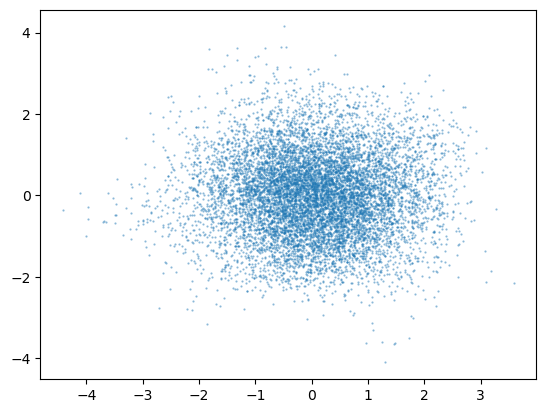

In [11]:
plt.scatter(samples[:,0], samples[:,-1], alpha=0.5, s=0.3)
metadata

{'L': 1.0,
 'step_size': 0.1,
 'acc_rate': Array(0.99910176, dtype=float32),
 'num_grads_per_proposal': 10.0,
 'num_tuning_grads': 0}

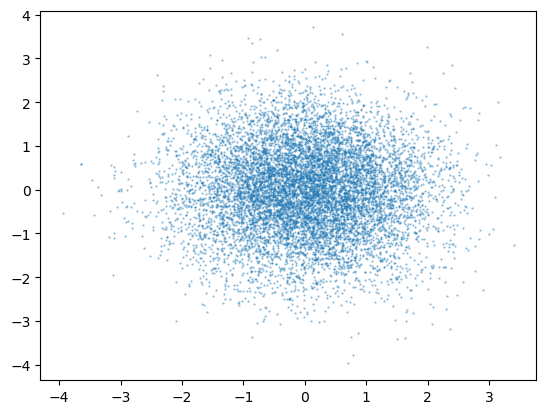

In [5]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)
metadata

In [8]:
# import oryx

# bijector = oryx.bijectors.IteratedSigmoidCentered(
#     validate_args=False, name='iterated_sigmoid'
# )
# bijector.forward_log_det_jacobian

<bound method Bijector.forward_log_det_jacobian of <tfp.bijectors.IteratedSigmoidCentered 'iterated_sigmoid' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>>

In [2]:
# import os
# # os.listdir("../../../../../../r")
# os.listdir("/global/homes/r/reubenh/sampler-benchmarks/sampler-comparison")

In [5]:
import tensorflow.compat.v2 as tf
import numpy as np
# import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax as tfp
from inference_gym.targets import model
import jax.numpy as jnp

tfb = tfp.bijectors
tfd = tfp.distributions

ndims = 2

dirichlet = tfp.distributions.Dirichlet(
        np.ones(ndims) * 100.0,
        validate_args=False,
        allow_nan_stats=True,
        force_probs_to_zero_outside_support=False,
        name='Dirichlet'
    )

dirichlet.mean(), dirichlet.stddev()

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


(Array([0.5, 0.5], dtype=float32),
 Array([0.03526728, 0.03526728], dtype=float32))

In [4]:
# dirichlet.unnormalized_log_prob(dirichlet.sample(seed=jax.random.key(0)))

In [2]:
# # model.sample(seed=jax.random.key(0))
# model = banana()
# model.sample(seed=jax.random.key(0))

In [2]:
from sampler_evaluation.models import models
# from sampler_evaluation.models.standardgaussian import Gaussian
import sampler_evaluation
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.dirichlet import Dirichlet
from sampler_evaluation.models.banana import banana
# import oryx
# sampler_evaluation.models.Rosenbrock(D=1)
model = Dirichlet(alpha=jnp.ones(2,)+100)
# model = IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')
# model = banana()
# model.sample(seed=jax.random.key(0))
# model._unnormalized_log_prob(jnp.ones(2))

samples, metadata = samplers['nuts'](return_samples=True)(
        # model=gym.targets.rosenbrock.Rosenbrock(D=2), 
        model=model, 
        num_steps=1000,
        initial_position=model.sample(seed=jax.random.key(0)), 
        # initial_position=jnp.ones((1,)), 
        key=jax.random.PRNGKey(0))


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

In [25]:
# jax.tree.map(lambda x: x.fn(model.default_event_space_bijector(jnp.ones((1,)))), model.sample_transformations)
# jax.tree.map(lambda x: x(0), model.sample_transformations)
foo = {trans: model.sample_transformations[trans].fn(model.default_event_space_bijector(jnp.ones((1,)))) for trans in model.sample_transformations
}

jax.tree.map_with_path(lambda path, x: (path[0].key+x), {7: 1, 3: 2})

bar = jax.tree.map_with_path(lambda path, expectation : jnp.max(
                    jnp.square(
                        expectation - model.sample_transformations[path[0].key].ground_truth_mean
                    )
                    / (
                        model.sample_transformations[path[0].key].ground_truth_standard_deviation
                        ** 2)), foo)
# model.sample_transformations

bar

{'identity': Array(43.351112, dtype=float32)}

In [7]:
bij = tfb.IteratedSigmoidCentered(validate_args=False,name='iterated_sigmoid'  )

bij.inverse(model.sample(seed=jax.random.key(0)))

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


Array([], shape=(0,), dtype=float32)

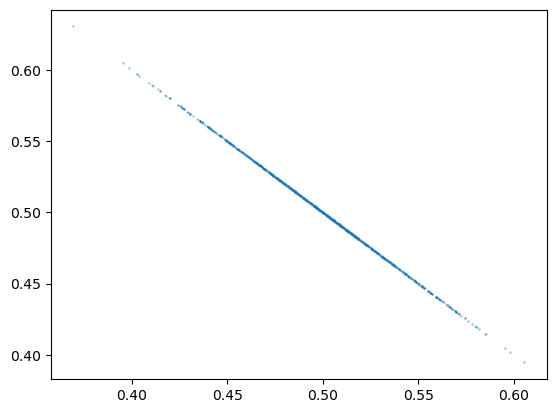

In [10]:
# scatter plot of samples
# samples[0]
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

In [4]:
samples.mean(axis=0)
# jax.vmap(lambda k: model.sample(seed=k))(jax.random.split(jax.random.key(0), 1000)).mean(axis=0)

Array([0.5008018, 0.4991982], dtype=float32)

In [6]:
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error


keys = jax.random.split(jax.random.key(0), 10)
init_keys = jax.random.split(jax.random.key(0), 10)
initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

squared_errors, metadata = jax.vmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=2000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors['identity']['max'], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()

final error is 0.0007830436807125807


Array(710.2451, dtype=float32)

Array(1.4101266e-06, dtype=float32)

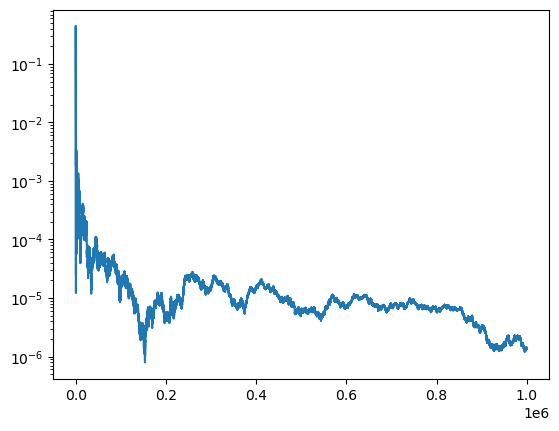

In [15]:
# samples.shape
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error

error_at_each_step = get_standardized_squared_error(
    jnp.expand_dims(samples,0), 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    )

error_at_each_step.shape

# gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()

# samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

# print("Gradient calls to low error", samples_to_low_err)

# plot error_at_each_step
plt.plot(error_at_each_step[0])
# log scale
plt.yscale('log')
# plt.xscale('log')
error_at_each_step[0,-1]

In [3]:
# load df from results
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models import models

# show paths available
# os.listdir(os.path.join('../', 'results'))

# sys.path.append('../../../')

df = pd.concat([pd.read_csv(os.path.join('..','results', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['demo.py', 'demo.ipynb']


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

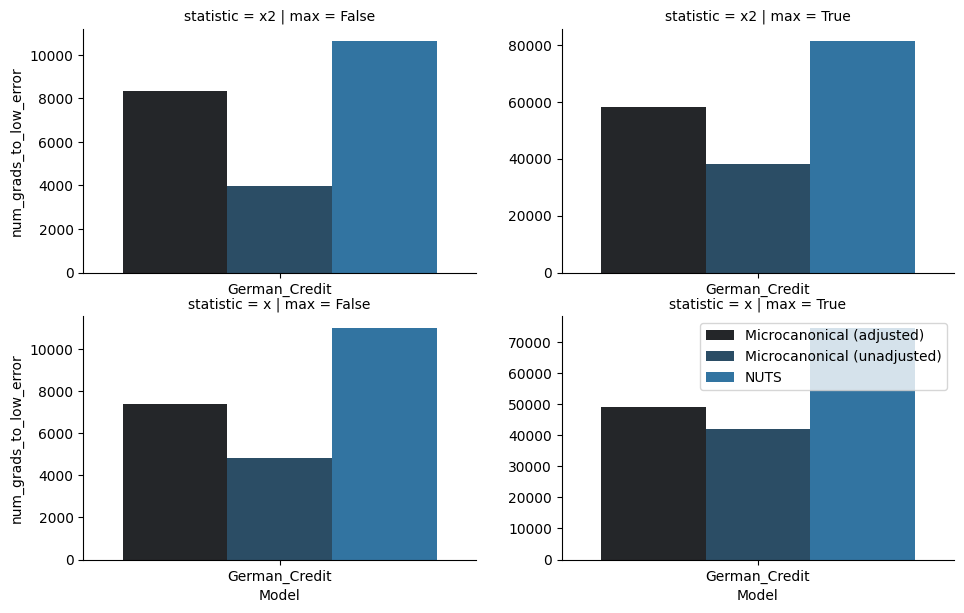

In [4]:
import numpy as np


def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({"nuts": "NUTS", "unadjusted_microcanonical": "Microcanonical (unadjusted)", "adjusted_microcanonical": "Microcanonical (adjusted)"}.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'Model',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["Model"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  # plt.yscale('log')

  plt.gcf().set_size_inches(10, 6)
  plt.show()

# df

# display_results("Gaussian_100D", df, include_tuning=False)
display_results("German_Credit", df, include_tuning=False)
# display_results("Brownian_Motion", df, include_tuning=False)
# display_results("Brownian_Motion", df, include_tuning=False)
# df

In [3]:
import pickle
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns



def compare(model):

        dirr = "/global/homes/r/reubenh/sampler-benchmarks"
        with open(f"{dirr}/sampler-evaluation/sampler_evaluation/models/data/{model.name}_expectations.pkl", "rb") as f:
                stats = pickle.load(f)
                e_x = stats['e_x']
                print("from blackjax run: ", e_x)

        print("from gym: ", model.sample_transformations['identity'].ground_truth_mean)

        
model = gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True)

compare(model)

from blackjax run:  [ 0.11525708  0.09256472  0.05635736 -0.03410918 -0.05100336 -0.18196875
 -0.18945307 -0.25923407 -0.25987643 -0.32402724 -0.22958763 -0.28165078
 -0.3362609  -0.38868254 -0.44175696 -0.4945148  -0.5447676  -0.6013282
 -0.6559048  -0.7087315  -0.75866866 -0.8134075  -0.8074223  -0.7784713
 -0.82167107 -0.7737639  -0.743899   -0.7613981  -0.6401507  -0.6669518
 -0.64461184  0.11305185]
from gym:  [ 0.11984811  0.10274264  0.06093274 -0.03870019 -0.04362268 -0.19021639
 -0.1856622  -0.26851514 -0.26010785 -0.3334386  -0.21788554 -0.2735482
 -0.33083084 -0.38252977 -0.43280044 -0.49400684 -0.54860604 -0.60449123
 -0.65569454 -0.7083658  -0.76391494 -0.8189823  -0.8105346  -0.7771473
 -0.8268097  -0.7768991  -0.7374106  -0.7740582  -0.6294383  -0.670295
 -0.6432216   0.10105278]


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

In [3]:
# class Brownian():
#     """
#     log sigma_i ~ N(0, 2)
#     log sigma_obs ~N(0, 2)

#     x ~ RandomWalk(0, sigma_i)
#     x_observed = (x + noise) * mask
#     noise ~ N(0, sigma_obs)
#     mask = 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
#     """

#     def __init__(self):
        
#         self.name = 'Brownian'
#         self.num_data = 30
#         self.ndims = self.num_data + 2

#         # self.E_x, self.E_x2, self.Var_x2, self.cov, self.inv_cov = load_cov(self.name)
        
#         self.data = jnp.array([0.21592641, 0.118771404, -0.07945447, 0.037677474, -0.27885845, -0.1484156, -0.3250906, -0.22957903,
#                                -0.44110894, -0.09830782, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.8786016, -0.83736074,
#                                -0.7384849, -0.8939254, -0.7774566, -0.70238715, -0.87771565, -0.51853573, -0.6948214, -0.6202789])
#         # sigma_obs = 0.15, sigma_i = 0.1

#         self.observable = jnp.concatenate((jnp.ones(10), jnp.zeros(10), jnp.ones(10)))
#         self.num_observable = jnp.sum(self.observable)  # = 20
        

#     def logdensity_fn(self, x):
#         # y = softplus_to_log(x[:2])

#         lik = 0.5 * jnp.exp(-2 * x[1]) * jnp.sum(self.observable * jnp.square(x[2:] - self.data)) + x[
#             1] * self.num_observable
#         prior_x = 0.5 * jnp.exp(-2 * x[0]) * (x[2] ** 2 + jnp.sum(jnp.square(x[3:] - x[2:-1]))) + x[0] * self.num_data
#         prior_logsigma = 0.5 * jnp.sum(jnp.square(x / 2.0))

#         return -lik - prior_x - prior_logsigma


#     def transform(self, x):
#         return jnp.concatenate((jnp.exp(x[:2]), x[2:]))

# class GermanCredit:
#     """ Taken from inference gym.

#         x = (global scale, local scales, weights)

#         global_scale ~ Gamma(0.5, 0.5)

#         for i in range(num_features):
#             unscaled_weights[i] ~ Normal(loc=0, scale=1)
#             local_scales[i] ~ Gamma(0.5, 0.5)
#             weights[i] = unscaled_weights[i] * local_scales[i] * global_scale

#         for j in range(num_datapoints):
#             label[j] ~ Bernoulli(features @ weights)

#         We use a log transform for the scale parameters.
#     """

#     def __init__(self):
        
#         self.name = 'GermanCredit'
#         self.ndims = 51 #global scale + 25 local scales + 25 weights

#         dirr = "../../../../MicroCanonicalHMC/benchmarks/"
        

#         self.labels = jnp.load(dirr + 'data/gc_labels.npy')
#         self.features = jnp.load(dirr + 'data/gc_features.npy')

#         # self.E_x, self.E_x2, self.Var_x2, self.cov, self.inv_cov = load_cov(self.name)
        
        
#     def transform(self, x):
#         return jnp.concatenate((jnp.exp(x[:26]), x[26:]))

#     def logdensity_fn(self, x):

#         scales = jnp.exp(x[:26])

#         # prior
#         pr = jnp.sum(0.5 * scales + 0.5 * x[:26]) + 0.5 * jnp.sum(jnp.square(x[26:]))

#         # transform
#         transform = -jnp.sum(x[:26])

#         # likelihood
#         weights = scales[0] * scales[1:26] * x[26:]
#         logits = self.features @ weights # = jnp.einsum('nd,...d->...n', self.features, weights)
#         lik = jnp.sum(self.labels * jnp.logaddexp(0., -logits) + (1-self.labels)* jnp.logaddexp(0., logits))

#         return -(lik + pr + transform)

sys.path.append(".")
sys.path.append("../../../../sampler-evaluation")
sys.path.append("../../../../MicroCanonicalHMC/benchmarks/")
import os
# print(os.listdir('../../MicroCanonicalHMC/benchmarks/'), "\n\n\n barbarz \n\n\n")

import inference_models
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['demo.py', 'demo.ipynb']


Exception: Expectations not found: run estimate_expectations.py to generate them

'banana'

In [8]:
Brownian().logdensity_fn(jnp.ones((32,)))

Array(-57.037537, dtype=float32)

In [ ]:
def make_target_log_prob_fn(model):
  def target_log_prob_fn(z):
    x = model.default_event_space_bijector(z)
    return (model.unnormalized_log_prob(x) + 
            model.default_event_space_bijector.forward_log_det_jacobian(z, event_ndims=1))
  return target_log_prob_fn


In [20]:
# from sampler_comparison.samplers.general import initialize_model, make_transform
# from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
# from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc

# # model = gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations()
# # model = gym.targets.Banana()

# def initialize_model(model, key):

#   def random_initialization(shape, dtype):
#     return jax.tree.map(lambda d, s: jnp.ones(shape=s, dtype=d), dtype, shape)

#   z = jax.tree.map(lambda d, b, s: random_initialization(b.inverse_event_shape(s), d),
#                         model.dtype, model.default_event_space_bijector, model.event_shape)

#   # x = jax.tree.map(lambda z, b: b(z), z, model.default_event_space_bijector)

#   return z

# initial_position = initialize_model(model, key=jax.random.PRNGKey(0))


# model.unnormalized_log_prob(make_transform(model)(initial_position)) 
# # + model.default_event_space_bijector.forward_log_det_jacobian(initial_position, event_ndims=1)
# # model.unnormalized_log_prob(initial_position)

# # jax.tree.map(lambda b, z: b(z), gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations().default_event_space_bijector, foo)

# # BrownianMotionUnknownScalesMissingMiddleObservations().default_event_space_bijector

# # samples, metadata = nuts(return_samples=True)(
# #         # model=gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), 
# #         model=model, 
# #         num_steps=1000,
# #         # initial_position=initialize_model(model, key=jax.random.PRNGKey(0)), 
# #         initial_position=initialize_model(model, key=jax.random.PRNGKey(0)), 
# #         key=jax.random.PRNGKey(0))

# # make_transform(model)(initial_position)

# # jax.tree.map(lambda x: 1,make_transform(model)(initial_position))


model = gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True)

model.sample_transformations[ "identity"
                        ].ground_truth_mean

# model = gym.targets.VectorModel(gym.targets.GermanCreditNumericSparseLogisticRegression(), flatten_sample_transformations=True)
# model = gym.targets.VectorModel(gym.targets.VectorizedStochasticVolatilityLogSP500(), flatten_sample_transformations=True)
# model.event_shape

# model = gym.targets.VectorModel(gym.targets.SyntheticItemResponseTheory(), flatten_sample_transformations=True)

# model.default_event_space_bijector


# print(jax.grad(target_log_prob_fn)(jnp.ones((51,))))
# print(jax.grad(GermanCredit().logdensity_fn)(jnp.ones((51,))))

# print(jax.grad(make_target_log_prob_fn(model))(jnp.ones((501,))))
# print(jax.grad(inference_models.ItemResponseTheory().logdensity_fn)(jnp.ones((501,))))

# print(jax.grad(make_target_log_prob_fn(model))(jnp.ones((2519,))))
# print(jax.grad(inference_models.StochasticVolatility().logdensity_fn)(jnp.ones((2519,))))
# print(inference_models.StochasticVolatility().logdensity_fn(jnp.ones((2429,))))

# print(target_log_prob_fn(jnp.ones((32,))))
# print(Brownian().logdensity_fn(jnp.ones((32,))))

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

Array([ 0.11984811,  0.10274264,  0.06093274, -0.03870019, -0.04362268,
       -0.19021639, -0.1856622 , -0.26851514, -0.26010785, -0.3334386 ,
       -0.21788554, -0.2735482 , -0.33083084, -0.38252977, -0.43280044,
       -0.49400684, -0.54860604, -0.60449123, -0.65569454, -0.7083658 ,
       -0.76391494, -0.8189823 , -0.8105346 , -0.7771473 , -0.8268097 ,
       -0.7768991 , -0.7374106 , -0.7740582 , -0.6294383 , -0.670295  ,
       -0.6432216 ,  0.10105278], dtype=float32)

In [21]:
# import os
import pickle
# os.listdir("../../../sampler-evaluation/sampler_evaluation/models/data/")
with open(f"../../../sampler-evaluation/sampler_evaluation/models/data/{model.name}_expectations.pkl", "rb") as f:
        stats = pickle.load(f)

e_x = stats["e_x"]
e_x

array([ 0.11523843,  0.11286443,  0.09281074,  0.05646418, -0.03425717,
       -0.05085291, -0.18207422, -0.18943499, -0.2626584 , -0.262576  ,
       -0.32351834, -0.22948493, -0.28225303, -0.33584505, -0.38882157,
       -0.44218862, -0.49562865, -0.5478393 , -0.6018324 , -0.6544354 ,
       -0.7073747 , -0.7601094 , -0.8155371 , -0.81037855, -0.78281546,
       -0.82298577, -0.7782092 , -0.74123335, -0.7644323 , -0.63898563,
       -0.6667262 , -0.643427  ], dtype=float32)

In [25]:

print(gym.targets.VectorModel(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations(), flatten_sample_transformations=True).sample_transformations["identity"].ground_truth_mean)
print(gym.targets.BrownianMotionUnknownScalesMissingMiddleObservations().sample_transformations["identity"].ground_truth_mean)

[ 0.11984811  0.10274264  0.06093274 -0.03870019 -0.04362268 -0.19021639
 -0.1856622  -0.26851514 -0.26010785 -0.3334386  -0.21788554 -0.2735482
 -0.33083084 -0.38252977 -0.43280044 -0.49400684 -0.54860604 -0.60449123
 -0.65569454 -0.7083658  -0.76391494 -0.8189823  -0.8105346  -0.7771473
 -0.8268097  -0.7768991  -0.7374106  -0.7740582  -0.6294383  -0.670295
 -0.6432216   0.10105278]
{'innovation_noise_scale': array(0.11984811), 'observation_noise_scale': array(0.10105278), 'locs': array([ 0.10274264,  0.06093274, -0.03870019, -0.04362268, -0.19021639,
       -0.1856622 , -0.26851513, -0.26010784, -0.3334386 , -0.21788554,
       -0.27354819, -0.33083084, -0.38252977, -0.43280044, -0.49400684,
       -0.54860601, -0.60449125, -0.65569453, -0.70836578, -0.76391497,
       -0.8189823 , -0.81053462, -0.7771473 , -0.82680971, -0.77689911,
       -0.73741063, -0.7740582 , -0.62943829, -0.67029499, -0.6432216 ])}


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

['demo.py', 'demo.ipynb']


Exception: Expectations not found: run estimate_expectations.py to generate them

NameError: name 'df' is not defined

In [1]:
import sys
sys.path.append('..')
from sampler_comparison.samplers import samplers
from sampler_evaluation.models import banana




2025-02-03 14:05:41.825200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738620341.839458  261284 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738620341.844021  261284 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
import jax.numpy as jnp
import jax

Rosenbrock_36D().unnormalized_log_prob(jax.random.normal(shape=(36,), key=jax.random.PRNGKey(0)))

Array(-233.6276, dtype=float32)

In [5]:
samples, metadata = samplers['nuts'](return_samples=True)(
        model=Rosenbrock_36D(), 
        num_steps=1000,
        initial_position=jnp.ones(36), 
        key=jax.random.PRNGKey(0))

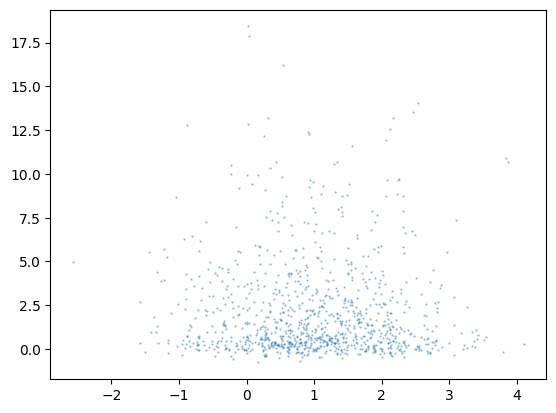

In [8]:
plt.scatter(samples[:,0], samples[:,-1], alpha=0.5, s=0.3)

In [14]:
import os
print(os.listdir())
import sys
sys.path.append(".")
sys.path.append("../../../sampler-comparison")
sys.path.append("../..")

import blackjax
from sampler_comparison.results.run_benchmarks import run_benchmarks
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
    adjusted_mclmc_tuning,
)
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import (
    unadjusted_mclmc,
    unadjusted_mclmc_tuning,
)
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import sampler_evaluation
from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
# from sampler_evaluation.models.gaussian import Gaussian
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
import jax.numpy as jnp
import blackjax
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts_tuning import da_adaptation
from sampler_comparison.samplers.general import (
    with_only_statistics,
    make_log_density_fn,
)
from sampler_comparison.util import *
from sampler_comparison.samplers.general import initialize_model
import jax


def get_cov_mat_nuts(num_tuning_steps, model, key=jax.random.key(0)):

    integrator_type = "velocity_verlet"



    integrator = map_integrator_type_to_integrator["hmc"][integrator_type]

    # model = brownian_motion()
    logdensity_fn = make_log_density_fn(model)


    warmup = blackjax.window_adaptation(
                    blackjax.nuts, logdensity_fn, integrator=integrator
                )

    warmup_key,init_key = jax.random.split(key)
    initial_position = initialize_model(model, init_key)

    (state, params), adaptation_info = warmup.run(
                    warmup_key, initial_position, num_tuning_steps
                )

    return params["inverse_mass_matrix"], adaptation_info.info.num_integration_steps.sum()


def get_cov_mat_mclmc(num_tuning_steps, model, key=jax.random.key(0)):

    # model = brownian_motion()
    logdensity_fn = make_log_density_fn(model)

    warmup_key,init_key = jax.random.split(key)
    initial_position = initialize_model(model, init_key)

    _, params, num_integrator_steps = unadjusted_mclmc_tuning(
        initial_position=initial_position,
        num_steps=1000,
        rng_key=warmup_key,
        logdensity_fn=logdensity_fn,
        integrator_type="mclachlan",
        diagonal_preconditioning=True,
        num_tuning_steps=num_tuning_steps,
    )

    return params.inverse_mass_matrix, num_integrator_steps

# def get_cov_mat_adjusted_mclmc(num_tuning_steps, model, key=jax.random.key(0)):

#     # model = brownian_motion()
#     logdensity_fn = make_log_density_fn(model)

#     warmup_key,init_key = jax.random.split(key)
#     initial_position = initialize_model(model, init_key)

#     _, params, _ = adjusted_mclmc_tuning(
#         initial_position=initial_position,
#         num_steps=1000,
#         rng_key=warmup_key,
#         logdensity_fn=logdensity_fn,
#         target_acc_rate=0.9,
#         integrator=map_integrator_type_to_integrator["mclmc"]['velocity_verlet'],
#         diagonal_preconditioning=True,
#         num_tuning_steps=num_tuning_steps,
#         L_proposal_factor=jnp.inf,
#         random_trajectory_length=True,
#         tuning_factor=1.0,
        

#     )

#     return params.inverse_mass_matrix

['debug.ipynb', 'other_ppls.ipynb', 'debug.py', 'demo.ipynb', 'other_ppls_2.ipynb']


In [7]:
nuts_inverse_mass_matrix, _ = get_cov_mat_nuts(num_tuning_steps=1000000, model=Rosenbrock_36D()) 

In [15]:
# get_cov_mat_mclmc(num_tuning_steps=100)-nuts_inverse_mass_matrix

results = []
nuts_results = []
adjusted_results = []
num_steps = []
nuts_num_steps = []
for i in [100, 1000, 10000, 100000,]:

    cov_mat, num_integrator_steps = get_cov_mat_mclmc(num_tuning_steps=i, model=Rosenbrock_36D(), key=jax.random.key(1))
    results.append(jnp.linalg.norm(cov_mat-nuts_inverse_mass_matrix).item())
    num_steps.append(num_integrator_steps)


    cov_mat, num_integrator_steps = get_cov_mat_nuts(num_tuning_steps=i, model=Rosenbrock_36D(), key=jax.random.key(1))
    nuts_results.append(jnp.linalg.norm(cov_mat-nuts_inverse_mass_matrix).item()) 
    nuts_num_steps.append(num_integrator_steps)
    # adjusted_results.append(jnp.linalg.norm(get_cov_mat_adjusted_mclmc(num_tuning_steps=i)-nuts_inverse_mass_matrix).item())

[Array(18434, dtype=int32),
 Array(141323, dtype=int32),
 Array(973746, dtype=int32),
 Array(9204909, dtype=int32)]

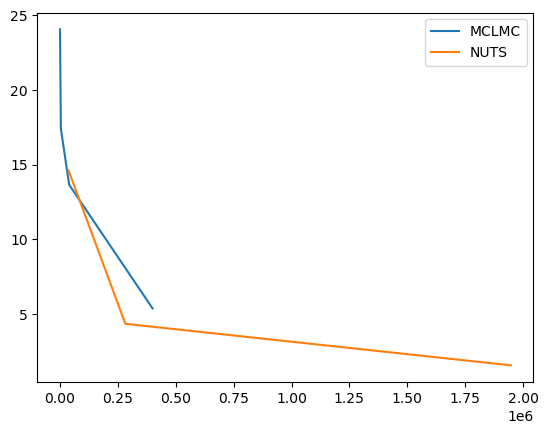

In [27]:
# plot results
import matplotlib.pyplot as plt
plt.plot([i*4 for i in num_steps[:4]], results[:4])
# plt.plot([100, 1000, 10000, 100000,], adjusted_results[:5])
plt.plot([i.item()*2 for i in nuts_num_steps[:3]], nuts_results[:3])
# plt.legend(["MCLMC", "Adjusted MCLMC", "NUTS"])
plt.legend(["MCLMC", "NUTS"])
# plt.yscale('log')
# plt.xscale('log')

# results, adjusted_results

nuts_num_steps

In [28]:
# import sys
0.25*1e6
# import pickle
# sys.path.append('..')
# from sampler_evaluation.models.rosenbrock import Rosenbrock_36D
# import jax.numpy as jnp
# dirr = "/global/homes/r/reubenh/sampler-benchmarks"

# with open(
#     f"{dirr}/sampler-evaluation/sampler_evaluation/models/data/rosenbrock_36D_expectations.pkl",
#     "rb",
# ) as f:
#     stats = pickle.load(f)

# print(f"New: {stats['e_x']}")

# e_x_old = jnp.array(
#             [
#                 1.0,
#             ]
#             *18
#             + [
#                 2.0,
#             ]
#             *18
#         )



# print(f"Old: {e_x_old}")

250000.0

In [1]:
import itertools
import os
import os
import sys
sys.path.append("../../../sampler-comparison/src/inference-gym/spinoffs/inference_gym")
print(os.listdir("../../../../"))
import pandas as pd
from sampler_comparison.samplers import samplers
# from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock
from sampler_evaluation.models.neals_funnel import neals_funnel
from sampler_evaluation.models.banana_mams_paper import banana_mams_paper
from sampler_comparison.samplers import samplers

models = [
    # banana(),
    IllConditionedGaussian(ndims=100, condition_number=1, eigenvalues='log'),
    Rosenbrock(),
    brownian_motion(),
    german_credit(),
    item_response(),
    stochastic_volatility_mams_paper,
]

models = {

    model.name: model

    for model in models
}

samplers = ["adjusted_malt", "nuts",  "adjusted_microcanonical", "adjusted_microcanonical_langevin", "underdamped_langevin", "unadjusted_microcanonical"]

# models = {
#     # "Banana_MAMS_Paper": banana_mams_paper,
#     banana().name: banana(),
#     # "Gaussian_MAMS_Paper": IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
#     brownian_motion().name: brownian_motion(),
#     # "German_Credit": german_credit(),
#     # "Rosenbrock": Rosenbrock(),
#     # "Neals_Funnel_MAMS_Paper": neals_funnel(),
#     # "Stochastic_Volatility_MAMS_Paper": stochastic_volatility_mams_paper,
#     # "Item_Response": item_response(),
# }

# samplers = {"nuts", "adjusted_microcanonical", ""}

df = pd.concat([pd.read_csv(os.path.join('../..',f'results/{model}', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

# use dictionary to rename  models to Standard Gaussian, Rosenbrock, Brownian Motion, German Credit, Item Response, Stochastic Volatility
model_names = {
    'ICG': 'Standard Gaussian',
    'rosenbrock_36d': 'Rosenbrock',
    'vector_brownian_motion_unknown_scales_missing_middle_observations': 'Brownian Motion',
    'vector_german_credit_numeric_sparse_logistic_regression': 'German Credit',
    'vector_synthetic_item_response_theory': 'Item Response',
    'Stochastic_Volatility_MAMS_Paper': 'Stochastic Volatility',
}
df['Model'] = df['Model'].map(model_names)



['probability', '.jupyter', 'sampler-benchmarks', 'blackjax', '.python_history-56867.tmp', 'resultsGaussian_linear_1.01020.csv', '.ssh', '.config', '.pytensor', '.bash_history', '.udiRoot', 'slurm-32797052.out', '.zsh_history', '.local', '.ipynb_checkpoints', 'tensorflow_datasets', '.dotnet', 'app.sh', '.nv', 'gridresultsGaussian_linear_1.01020.csv', 'conf.py', '.zcompdump', '.wget-hsts', 'slurm-32796382.out', '.cursor-server', '.python_history-51829.tmp', '.cupy', 'results', 'test.py', '.python_history-82917.tmp', '.keras', 'startscript', 'containers', '.conda', 'eps_n_leap_1001100.npy', 'HMCLib', 'MicroCanonicalHMC', '.python_history', '.ipython', '.lesshst', '.netrc', '.viminfo', '.cache', '.bashrc', '.vscode-server', 'src']


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [2]:
bias_df = df
bias_df = bias_df[bias_df['max']==False]
bias_df = bias_df[(bias_df['statistic'] == 'square') | (bias_df['statistic'] == 'covariance')]
bias_df["std_percent"] = 100*bias_df["grads_to_low_error_std"]/bias_df["num_grads_to_low_error"]
bias_df = bias_df[['std_percent', 'Sampler', 'Model', 'statistic', 'num_grads_to_low_error']]
bias_df

bias_df['Model']
bias_df['metric'] = bias_df['statistic']

# order the models as: Standard Gaussian, Rosenbrock, Brownian Motion, German Credit, Item Response, Stochastic Volatility
bias_df['Model'] = pd.Categorical(bias_df['Model'], categories=['Standard Gaussian', 'Rosenbrock', 'Brownian Motion', 'German Credit', 'Item Response', 'Stochastic Volatility'], ordered=True)

# rename metric by {square : $b_\mathit{avg}(x^2)$, covariance : b_\mathit{cov}}
bias_df['metric'] = bias_df['metric'].map({'square': '$b_\mathit{avg}$', 'covariance': '$b_\mathit{cov}$'})


In [3]:


# Convert the DataFrame to a LaTeX table with samplers as columns and models as rows
pivot_table = bias_df.pivot_table(
    values='std_percent', 
    index=['Model', 'metric'], 
    columns='Sampler',
    aggfunc='mean'  # Use mean in case there are duplicate entries
)

# rearrange the columns to be in the order: adjusted_malt (call it aLMC), underdamped_langevin (call it uLMC), adjusted_microcanonical (call it aMCLMC), unadjusted_microcanonical (call it uMCLMC), nuts (call it NUTS)
pivot_table = pivot_table[['adjusted_malt', 'underdamped_langevin', 'adjusted_microcanonical_langevin', 'unadjusted_microcanonical', 'nuts']]
# rename the columns to be aLMC, uLMC, aMCLMC, uMCLMC, NUTS
pivot_table.columns = ['aLMC', 'uLMC', 'aMCLMC', 'uMCLMC', 'NUTS']



# Format the table with NaN values displayed as '-'
formatted_table = pivot_table.fillna('-')

# Generate the LaTeX table
latex_table = formatted_table.to_latex(
    float_format=lambda x: f"{x:,.2f}\%" if isinstance(x, (int, float)) and not pd.isna(x) else "-",
    bold_rows=True,
    caption="Percentage of gradient evaluations used for standard error estimation",
    label="tab:bias_comparison"
)

print("LaTeX Table:")
print(latex_table)

# Display the pivot table in the notebook for reference
pivot_table


LaTeX Table:
\begin{table}
\caption{Percentage of gradient evaluations used for standard error estimation}
\label{tab:bias_comparison}
\begin{tabular}{llrrrrr}
\toprule
 &  & aLMC & uLMC & aMCLMC & uMCLMC & NUTS \\
Model & metric &  &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{\textbf{Standard Gaussian}} & \textbf{$b_\mathit{avg}$} & 0.42\% & 1.02\% & 1.51\% & 0.77\% & 0.13\% \\
\textbf{} & \textbf{$b_\mathit{cov}$} & 0.06\% & 0.32\% & 0.31\% & 0.29\% & 0.06\% \\
\cline{1-7}
\multirow[t]{2}{*}{\textbf{Rosenbrock}} & \textbf{$b_\mathit{avg}$} & 0.07\% & 5.69\% & 0.06\% & 2.05\% & 0.02\% \\
\textbf{} & \textbf{$b_\mathit{cov}$} & 0.03\% & 1.64\% & 0.01\% & 0.90\% & 0.01\% \\
\cline{1-7}
\multirow[t]{2}{*}{\textbf{Brownian Motion}} & \textbf{$b_\mathit{avg}$} & 0.37\% & 6.14\% & 0.38\% & 2.77\% & 0.16\% \\
\textbf{} & \textbf{$b_\mathit{cov}$} & 0.05\% & 4.96\% & 0.06\% & 0.49\% & 0.03\% \\
\cline{1-7}
\multirow[t]{2}{*}{\textbf{German Credit}} & \textbf{$b_\mathit{avg}$} & 0.06\% & 7.49\% 

/tmp/ipykernel_1001898/1976264389.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = bias_df.pivot_table(


aLMC       uLMC    aMCLMC  \
Model                 metric                                            
Standard Gaussian     $b_\mathit{avg}$  0.417710   1.019252  1.511158   
                      $b_\mathit{cov}$  0.060071   0.319234  0.313547   
Rosenbrock            $b_\mathit{avg}$  0.067977   5.689622  0.063165   
                      $b_\mathit{cov}$  0.025786   1.644178  0.013103   
Brownian Motion       $b_\mathit{avg}$  0.369348   6.143906  0.382440   
                      $b_\mathit{cov}$  0.054132   4.962438  0.063027   
German Credit         $b_\mathit{avg}$  0.063909   7.494157  0.101677   
                      $b_\mathit{cov}$  0.052784  11.576521  0.075670   
Item Response         $b_\mathit{avg}$  0.619811   8.078684  1.229930   
Stochastic Volatility $b_\mathit{avg}$  0.039831  17.378871  0.058023   

                                          uMCLMC      NUTS  
Model                 metric                                
Standard Gaussian     $b_\mathit{avg}$  0.766087  0.132129  
                      $b_\mathit{cov}$  0.286223  0.055863  
Rosenbrock            $b_\mathit{avg}$  2.054505  0.020888  
                      $b_\mathit{cov}$  0.902212  0.005306  
Brownian Motion       $b_\mathit{avg}$  2.773619  0.164660  
                      $b_\mathit{cov}$  0.491662  0.034259  
German Credit         $b_\mathit{avg}$  2.252558  0.042257  
                      $b_\mathit{cov}$  0.930871  0.046263  
Item Response         $b_\mathit{avg}$  4.108316  0.436203  
Stochastic Volatility $b_\mathit{avg}$  1.873404  0.017564

In [1]:
import itertools
import os
import os
import sys
sys.path.append("../../../sampler-comparison/src/inference-gym/spinoffs/inference_gym")
print(os.listdir("../../../../"))
import pandas as pd
from sampler_comparison.samplers import samplers
# from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock
from sampler_evaluation.models.neals_funnel import neals_funnel
from sampler_evaluation.models.banana_mams_paper import banana_mams_paper
from sampler_comparison.samplers import samplers
from sampler_evaluation.models.cauchy import cauchy
from sampler_evaluation.models.bimodal import bimodal_gaussian
from sampler_evaluation.models.banana import banana

models = [
    # banana(),
    IllConditionedGaussian(ndims=100, condition_number=1, eigenvalues='log'),
    Rosenbrock(),
    banana(),
    brownian_motion(),
    german_credit(),
    item_response(),
    bimodal_gaussian(),
    cauchy(ndims=100),
    stochastic_volatility_mams_paper,
]

models = {

    model.name: model

    for model in models
}

samplers = ["nuts",  "adjusted_microcanonical", ]
            # "adjusted_microcanonical_langevin"]

# models = {
#     # "Banana_MAMS_Paper": banana_mams_paper,
#     banana().name: banana(),
#     # "Gaussian_MAMS_Paper": IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
#     brownian_motion().name: brownian_motion(),
#     # "German_Credit": german_credit(),
#     # "Rosenbrock": Rosenbrock(),
#     # "Neals_Funnel_MAMS_Paper": neals_funnel(),
#     # "Stochastic_Volatility_MAMS_Paper": stochastic_volatility_mams_paper,
#     # "Item_Response": item_response(),
# }

# samplers = {"nuts", "adjusted_microcanonical", ""}

df = pd.concat([pd.read_csv(os.path.join('../..',f'results/{model}', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

# use dictionary to rename  models to Standard Gaussian, Rosenbrock, Brownian Motion, German Credit, Item Response, Stochastic Volatility
model_names = {
    'ICG': 'Standard Gaussian',
    'rosenbrock_36d': 'Rosenbrock',
    'vector_brownian_motion_unknown_scales_missing_middle_observations': 'Brownian Motion',
    'vector_german_credit_numeric_sparse_logistic_regression': 'German Credit',
    'vector_synthetic_item_response_theory': 'Item Response',
    'Stochastic_Volatility_MAMS_Paper': 'Stochastic Volatility',
    'banana': 'Banana',
    'BimodalGaussian': 'Bimodal Gaussian',
    'Cauchy_100D': 'Cauchy',

}
df['Model'] = df['Model'].map(model_names)




['probability', '.jupyter', 'sampler-benchmarks', 'blackjax', '.python_history-56867.tmp', 'resultsGaussian_linear_1.01020.csv', '.ssh', '.config', '.pytensor', '.bash_history', '.udiRoot', 'slurm-32797052.out', '.zsh_history', '.local', '.ipynb_checkpoints', 'tensorflow_datasets', '.dotnet', 'app.sh', '.nv', 'gridresultsGaussian_linear_1.01020.csv', 'conf.py', '.zcompdump', '.wget-hsts', 'slurm-32796382.out', '.cursor-server', '.python_history-51829.tmp', '.cupy', 'results', 'test.py', '.python_history-82917.tmp', '.keras', 'startscript', 'containers', '.conda', 'eps_n_leap_1001100.npy', 'HMCLib', 'MicroCanonicalHMC', '.python_history', '.ipython', '.lesshst', '.netrc', '.viminfo', '.cache', '.bashrc', '.vscode-server', 'src']


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

In [2]:
# display full df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(df)

In [3]:
mams_df = df
mams_df["do_max"] = mams_df["Model"].apply(lambda x: {
    'Standard Gaussian': False,
    'Rosenbrock': False,
    'Brownian Motion': True,
    'German Credit': True,
    'Item Response': True,
    'Stochastic Volatility': True,
    'Bimodal Gaussian': True,
    'Cauchy': False,
    'Banana': True,
}.get(x, False))
mams_df = mams_df[mams_df['max']==mams_df["do_max"]]
mams_df = mams_df[(mams_df['statistic'] == 'square') | (mams_df['statistic'] == 'entropy')]
mams_df["std_percent"] = 100*mams_df["grads_to_low_error_std"]/mams_df["num_grads_to_low_error"]
mams_df = mams_df[['std_percent', 'Sampler', 'Model', 'statistic', 'do_max']]
mams_df



# raise Exception
# raise Exception

# mams_df['Model']
mams_df['metric'] = mams_df['statistic']

# print(mams_df)

# raise Exception

# order the models as: Standard Gaussian, Rosenbrock, Brownian Motion, German Credit, Item Response, Stochastic Volatility
# mams_df['Model'] = pd.Categorical(mams_df['Model'], categories=['Standard Gaussian', 'Rosenbrock', 'Cauchy', 'Bimodal Gaussian', 'Banana', 'Brownian Motion', 'German Credit', 'Item Response', 'Stochastic Volatility'], ordered=True)

# rename metric by {square : $b_\mathit{avg}(x^2)$, covariance : b_\mathit{cov}}
mams_df['metric'] = mams_df["do_max"].map({True: '$b_\mathit{max}$', False: '$b_\mathit{avg}$'})



# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(mams_df)



# Convert the DataFrame to a LaTeX table with samplers as columns and models as rows
pivot_table = mams_df.pivot_table(
    values='std_percent', 
    index=['Model', 'metric'], 
    columns='Sampler',
    aggfunc='mean'  # Use mean in case there are duplicate entries
)





# # rearrange the columns to be in the order: adjusted_malt (call it aLMC), underdamped_langevin (call it uLMC), adjusted_microcanonical (call it aMCLMC), unadjusted_microcanonical (call it uMCLMC), nuts (call it NUTS)
# pivot_table = pivot_table[['adjusted_microcanonical', 'nuts']]
pivot_table.columns = ['MAMS', 'NUTS']



# # Format the table with NaN values displayed as '-'
formatted_table = pivot_table.fillna('-')

# Generate the LaTeX table
latex_table = formatted_table.to_latex(
    float_format=lambda x: f"{x:.2f}\%" if isinstance(x, (int, float)) and not pd.isna(x) else "-",
    bold_rows=True,
    caption="",
    label="tab:bias_comparison"
)

print("LaTeX Table:")
print(latex_table)

# Display the pivot table in the notebook for reference
pivot_table
# mams_df["do_max"]


LaTeX Table:
\begin{table}
\label{tab:bias_comparison}
\begin{tabular}{llrr}
\toprule
 &  & MAMS & NUTS \\
Model & metric &  &  \\
\midrule
\textbf{Banana} & \textbf{$b_\mathit{max}$} & 0.42\% & 1.52\% \\
\cline{1-4}
\textbf{Bimodal Gaussian} & \textbf{$b_\mathit{max}$} & 6.34\% & 2.07\% \\
\cline{1-4}
\textbf{Brownian Motion} & \textbf{$b_\mathit{max}$} & 0.36\% & 0.22\% \\
\cline{1-4}
\textbf{Cauchy} & \textbf{$b_\mathit{avg}$} & 5.37\% & 0.02\% \\
\cline{1-4}
\textbf{German Credit} & \textbf{$b_\mathit{max}$} & 0.12\% & 0.09\% \\
\cline{1-4}
\textbf{Item Response} & \textbf{$b_\mathit{max}$} & 1.05\% & 0.17\% \\
\cline{1-4}
\textbf{Rosenbrock} & \textbf{$b_\mathit{avg}$} & 0.06\% & 0.02\% \\
\cline{1-4}
\textbf{Standard Gaussian} & \textbf{$b_\mathit{avg}$} & 1.04\% & 0.13\% \\
\cline{1-4}
\textbf{Stochastic Volatility} & \textbf{$b_\mathit{max}$} & 0.10\% & 0.09\% \\
\cline{1-4}
\bottomrule
\end{tabular}
\end{table}



,,MAMS,NUTS
Model,metric,,
Banana,$b_\mathit{max}$,0.417319,1.523760
Bimodal Gaussian,$b_\mathit{max}$,6.336115,2.068287
Brownian Motion,$b_\mathit{max}$,0.363603,0.222571
Cauchy,$b_\mathit{avg}$,5.374161,0.019107
German Credit,$b_\mathit{max}$,0.123766,0.088407
Item Response,$b_\mathit{max}$,1.052002,0.169529
Rosenbrock,$b_\mathit{avg}$,0.061834,0.020888
Standard Gaussian,$b_\mathit{avg}$,1.042585,0.132129
Stochastic Volatility,$b_\mathit{max}$,0.095751,0.088730
